Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menu bar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menu bar, select Cell$\rightarrow$Run All).

Make sure that in addition to the code, you provide written answers for all questions of the assignment. 

Below, please fill in your name:

In [128]:
let NAME = "Alexey Adamsky"

## Assignment 1 - Data Cleaning & Exploration
**(30 points total)**

For this assignment, we will use an open dataset with data on various types of cereal and the corresponding customer ratings. Use the .csv file provided.

Create a dataframe by importing the file into Jupyter, and complete the tasks below. Be sure to show your Python code. You will not be graded on code efficiency, but your code should return a correct answer.

**Question 1.**  _(4 points)_
* Create a new 'Type of Cereal' column in your dataframe (1 point) by copying the 'name' column. Write a function to replace the names of the cereal in your new column with one of these categories Bran, Wheat, Fiber, Protein, Crunch, Corn, Nut, Rice and Other (3 points). Hint: the function should look through the text in the cereal name and determine, based on its contents, how to categorize the cereal type.

**Question 2.**  _(2 points)_
* Identify the negative values in the data set and replace them with the median value for that column.

**Question 3.** _(5 points)_
* Standardize the 'weight' column to 1. For this question, you will need to write a function to divide the remaining columns which contain nutritional information by the corresponding value in the weight column, and you will need to divide the value in the weight column by itself in order to get 1. For example, if an observation has a weight value of 1.33 and a calories value of 250, if you divide 250/1.33 you should get a calories value of 188 and a weight value of 1.

**Question 4.**  _(5 points)_
* Create a new column to categorize cereals as 'healthy' vs. 'unhealthy'. You can define your own version of healthy vs. unhealthy, or you can use the following: healthy cereals can be defined as those which have low calories (<100), low sodium (<150), low sugar (<9) high fiber (>3), and high protein (>2). All other cereals are unhealthy.

**Question 5.** _(2 points)_
* Based on your newly prepared data set identify what % of cereals that each manufacturer produces are healthy.

**Question 6.** _(2 points)_
* Calculate the average, minimum and maximum ratings for healthy vs. unhealthy cereals.

**Question 7.** _(2 points)_
* Calculate the average, minimum and maximum ratings for each type of cereal: Bran, Wheat, Fiber, Protein, Crunch, Corn, Nut, Rice and Other.

**Question 8.** _(3 points)_
* Create a stacked bar chart which shows how many of each type of cereal each manufacturer produces.

**Question 9.** _(3 points)_
* Create a 3-dimensional scatterplot which shows the relationship between rating and calories; the 3-rd dimension should be reflected in the color of the dots and should highlight whether the cereal is categorized as healthy or unhealthy.

**Question 10.** _(1 point)_
* Which shelf has the most healthy cereals?

**Question 11.** _(1 point)_
* Based on the analysis conducted, what can you conclude about the cereal data set?

In [129]:
#r "nuget:Deedle.Interactive,3.0.0-beta.1"
#r "nuget:FSharp.Stats"
#r "nuget:Plotly.NET.Interactive"

Installed Packages Deedle.Interactive, 3.0.0-beta.1 FSharp.Stats, 0.4.9 Plotly.NET.Interactive, 3.0.2

In [130]:
open Deedle
open FSharp.Stats
open Plotly.NET
open FSharp.Stats.Fitting.LinearRegression

In [131]:
let df = Frame.ReadCsv("cereal.csv")

In [132]:
df

0,->,100% Bran,N,C,70,4,1,130,10,5,6,280,25,3,1,0.33,68.402973
1,->,100% Natural Bran,Q,C,120,3,5,15,2,8,8,135,0,3,1,1,33.983679
2,->,All-Bran,K,C,70,4,1,260,9,7,5,320,25,3,1,0.33,59.425505
3,->,All-Bran with Extra Fiber,K,C,50,4,0,140,14,8,0,330,25,3,1,0.5,93.704912
4,->,Almond Delight,R,C,110,2,2,200,1,14,8,-1,25,3,1,0.75,34.384843
:,,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,->,Triples,G,C,110,2,1,250,0,21,3,60,25,3,1,0.75,39.106174
73,->,Trix,G,C,110,1,1,140,0,13,12,25,25,2,1,1,27.753301
74,->,Wheat Chex,R,C,100,3,1,230,3,17,3,115,25,1,1,0.67,49.787445
75,->,Wheaties,G,C,100,3,1,200,3,17,3,110,25,1,1,1,51.592193
76,->,Wheaties Honey Gold,G,C,110,2,1,200,1,16,8,60,25,1,1,0.75,36.187559


### Helpers

In [170]:
// https://stackoverflow.com/a/74260934/977406

let info (df: Deedle.Frame<'a,'b>) =
    let dt = df.GetFrameData()
    let countOptionalValues d =
        d
        |> Seq.filter (
            function
            | OptionalValue.Present _ -> true
            | _ -> false
        )
        |> Seq.length

    Seq.zip dt.ColumnKeys dt.Columns
    |> Seq.map (fun (col, (ty, vec)) ->
        {|
            Column = col
            ``Non-Null Count`` =
                match vec.Data with
                | Vectors.VectorData.DenseList d -> $"%i{d |> Seq.length} non-null"
                | Vectors.VectorData.SparseList d -> $"%i{d |> countOptionalValues} non-null"
                | Vectors.VectorData.Sequence d -> $"%i{d |> countOptionalValues} non-null"
            Dtype = ty
        |}
    )

let unique (col: string) (df: Deedle.Frame<'a, string>)=
    df.GetColumn<string> col
    |> Series.values
    |> Seq.distinct
    |> String.concat ", "

let describe (df: Frame<'a, 'b>) =
    let describeable =
        df.ColumnTypes
        |> Seq.mapi (
            fun i v ->
                match v.Name with
                | nameof System.Int32
                | nameof System.Decimal
                | nameof System.Double -> true
                | _ -> false
        )

    let colNames =
        Seq.zip df.ColumnKeys describeable
        |> Seq.filter (fun (_, d) -> d)
        |> Seq.map (fun (n, _) -> n)

    Frame.ofRowsOrdinal (
        colNames
        |> Seq.map (fun c -> df.GetColumn<decimal> c |> Stats.describe) // TODO: can we add "count"? similar to pandas
    )
    |> Frame.transpose
    |> Frame.indexColsWith colNames

let mapAndReplaceCol n fn (df: Frame<'a, 'b>) =
    df.ReplaceColumn (n, df[n] |> Series.map (fun i v -> v |> fn))

let aggregateRowsBy grpBy rowsAggs df =
    let rec aggRowsBy rowsAggs (aggDf: Frame<string,'a> option) =
        match rowsAggs with
        | [] ->
            aggDf.Value // will throw an expecption if value is None
        | (rowName, aggFn, aggName)::tail ->
            let aggregatedDf =
                df
                |> Frame.aggregateRowsBy [grpBy] [rowName] aggFn
                |> Frame.indexRowsString grpBy
            aggregatedDf.RenameColumn(rowName,aggName)

            match aggDf with
            | None ->
                aggregatedDf
                |> Some
                |> aggRowsBy tail
            | Some aDf ->
                aggregatedDf
                |> Frame.join JoinKind.Left aDf
                |> Some
                |> aggRowsBy tail

    aggRowsBy rowsAggs None

let getColVector col (df: Frame<'a, 'b>) =
    vector <| df.[col].Values

let singleGroupLmplot yCol xCol valuesName df =
    let y = df |> getColVector yCol
    let x = df |> getColVector xCol

    let coefs = OrdinaryLeastSquares.Linear.Univariable.coefficient x y
    let fittinFunc x = OrdinaryLeastSquares.Linear.Univariable.fit coefs x
    let xRange = [for i in Seq.min(x)..Seq.max(x) -> i]
    let yPredicted = [for x in xRange -> fittinFunc x]

    let xy = Seq.zip xRange yPredicted
    [
        Chart.Point(x, y, ShowLegend=true, Name=valuesName)
        |> Chart.withXAxisStyle(TitleText=xCol)
        |> Chart.withYAxisStyle(TitleText=yCol)

        Chart.Line(xy, ShowLegend=true, Name=($"Reg. {valuesName}"))
    ]
    |> Chart.combine

let lmplot xCol yCol hue df =
    match hue with
    | None ->
        [ singleGroupLmplot xCol yCol ($"{xCol} vs {yCol}") df ]
    | Some h ->
        let groupedDf = df |> Frame.groupRowsByString h

        groupedDf.RowKeys
        |> Seq.map (fun (g, _) -> g)
        |> Seq.distinct
        |> List.ofSeq
        |> List.map (fun k ->
            groupedDf
            |> filterByKey (fun (g, _) -> g = k)
            |> singleGroupLmplot xCol yCol k
        )
    |> Chart.combine
    |> Chart.withLegendStyle(Orientation=StyleParam.Orientation.Horizontal)

In [134]:
// make sure `name` doesn't have any missing values
// we also see there are no missing values in any of the columns
df |> info

index,Column,Dtype,Non-Null Count
0,[ name ],System.String,77 non-null
1,[ mfr ],System.String,77 non-null
2,[ type ],System.String,77 non-null
3,[ calories ],System.Int32,77 non-null
4,[ protein ],System.Int32,77 non-null
5,[ fat ],System.Int32,77 non-null
6,[ sodium ],System.Int32,77 non-null
7,[ fiber ],System.Decimal,77 non-null
8,[ carbo ],System.Decimal,77 non-null
9,[ sugars ],System.Int32,77 non-null


In [135]:
df |> unique "name"

100% Bran, 100% Natural Bran, All-Bran, All-Bran with Extra Fiber, Almond Delight, Apple Cinnamon Cheerios, Apple Jacks, Basic 4, Bran Chex, Bran Flakes, Cap'n'Crunch, Cheerios, Cinnamon Toast Crunch, Clusters, Cocoa Puffs, Corn Chex, Corn Flakes, Corn Pops, Count Chocula, Cracklin' Oat Bran, Cream of Wheat (Quick), Crispix, Crispy Wheat & Raisins, Double Chex, Froot Loops, Frosted Flakes, Frosted Mini-Wheats, Fruit & Fibre Dates; Walnuts; and Oats, Fruitful Bran, Fruity Pebbles, Golden Crisp, Golden Grahams, Grape Nuts Flakes, Grape-Nuts, Great Grains Pecan, Honey Graham Ohs, Honey Nut Cheerios, Honey-comb, Just Right Crunchy  Nuggets, Just Right Fruit & Nut, Kix, Life, Lucky Charms, Maypo, Muesli Raisins; Dates; & Almonds, Muesli Raisins; Peaches; & Pecans, Mueslix Crispy Blend, Multi-Grain Cheerios, Nut&Honey Crunch, Nutri-Grain Almond-Raisin, Nutri-grain Wheat, Oatmeal Raisin Crisp, Post Nat. Raisin Bran, Product 19, Puffed Rice, Puffed Wheat, Quaker Oat Squares, Quaker Oatmeal, Ra

In [136]:
// Bran, Wheat, Fiber, Protein, Crunch, Corn, Nut, Rice and Other
let nameToCategory (n: string) =
    if (n.Contains "Bran") then "Bran"
    else if (n.Contains "Wheat") then "Wheat"
    else if (n.Contains "Fiber") then "Fiber"
    else if (n.Contains "Protein") then "Protein"
    else if (n.Contains "Crunch") then "Crunch"
    else if (n.Contains "Corn") then "Corn"
    else if (n.Contains "Nut") || (n.Contains "Almond") || (n.Contains "Walnut") || (n.Contains "Pecan") then "Nut"
    else if (n.Contains "Rice") then "Rice"
    else "Other"

In [137]:
df.GetColumn<string>("name")
|> Series.mapValues nameToCategory

0,->,Bran
1,->,Bran
2,->,Bran
3,->,Bran
4,->,Nut
...,->,...
72,->,Other
73,->,Other
74,->,Wheat
75,->,Wheat
76,->,Wheat


In [138]:
(
    "Type of Cereal",
    df.GetColumn<string>("name")
    |> Series.mapValues nameToCategory
)
|> df.AddColumn

In [139]:
df

0,->,100% Bran,N,C,70,4,1,130,10,5,6,280,25,3,1,0.33,68.402973,Bran
1,->,100% Natural Bran,Q,C,120,3,5,15,2,8,8,135,0,3,1,1,33.983679,Bran
2,->,All-Bran,K,C,70,4,1,260,9,7,5,320,25,3,1,0.33,59.425505,Bran
3,->,All-Bran with Extra Fiber,K,C,50,4,0,140,14,8,0,330,25,3,1,0.5,93.704912,Bran
4,->,Almond Delight,R,C,110,2,2,200,1,14,8,-1,25,3,1,0.75,34.384843,Nut
:,,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,->,Triples,G,C,110,2,1,250,0,21,3,60,25,3,1,0.75,39.106174,Other
73,->,Trix,G,C,110,1,1,140,0,13,12,25,25,2,1,1,27.753301,Other
74,->,Wheat Chex,R,C,100,3,1,230,3,17,3,115,25,1,1,0.67,49.787445,Wheat
75,->,Wheaties,G,C,100,3,1,200,3,17,3,110,25,1,1,1,51.592193,Wheat
76,->,Wheaties Honey Gold,G,C,110,2,1,200,1,16,8,60,25,1,1,0.75,36.187559,Wheat


In [140]:
// resulting categories
df |> unique "Type of Cereal"

Bran, Nut, Other, Crunch, Corn, Wheat, Rice

### **Question 2.**  _(2 points)_
* Identify the negative values in the data set and replace them with the median value for that column.

In [141]:
// these 3 columns have negative values "carbo, sugars and potass"
df |> describe

unique,->,11,6,5,27,13,22,17,36,3,3,7,12,77
mean,->,106.88311688311688,2.5454545454545454,1.0129870129870129,159.67532467532467,2.1519480519480516,14.597402597402597,6.922077922077922,96.07792207792208,28.246753246753247,2.207792207792208,1.0296103896103894,0.8210389610389613,42.66570498701299
std,->,19.48411905682084,1.094789748445534,1.006472559480393,83.83229524009316,2.383363964387222,4.278956280325908,4.4448853924193585,71.28681250926212,22.342522500566307,0.832524100135788,0.15047679973689349,0.2327161384469134,14.047288743735223
min,->,50,1,0,0,0,-1,-1,-1,0,1,0.5,0.25,18.042851
0.25,->,100,2,0,130,1,12,3,40,25,1,1,0.67,33.174094
0.5,->,110,3,1,180,2,14,7,90,25,2,1,0.75,40.400208
0.75,->,110,3,2,210,3,17,11,120,25,3,1,1,50.828392
max,->,160,6,5,320,14,23,15,330,100,3,1.5,1.5,93.704912


In [142]:
let carboMean = df["carbo"].Mean()
let sugarsMean = df["sugars"].Mean()
let potassMean = df["potass"].Mean()
let replaceWithMean m v = if v < 0. then m else v

df |> mapAndReplaceCol "carbo" (replaceWithMean carboMean)
df |> mapAndReplaceCol "sugars" (replaceWithMean sugarsMean)
df |> mapAndReplaceCol "potass" (replaceWithMean potassMean)

In [143]:
df |> describe

unique,->,11,6,5,27,13,3,3,7,12,77,22,17,36
mean,->,106.88311688311688,2.5454545454545454,1.0129870129870129,159.67532467532467,2.1519480519480516,28.246753246753247,2.207792207792208,1.0296103896103894,0.8210389610389613,42.66570498701299,14.799966267498736,7.024962050936077,98.5994265474785
std,->,19.48411905682084,1.094789748445534,1.006472559480393,83.83229524009316,2.383363964387222,22.342522500566307,0.832524100135788,0.15047679973689349,0.2327161384469134,14.047288743735223,3.8816048051572682,4.349770249291506,69.47923977411571
min,->,50,1,0,0,0,0,1,0.5,0.25,18.042851,5,0,15
0.25,->,100,2,0,130,1,25,1,1,0.67,33.174094,12,3,45
0.5,->,110,3,1,180,2,25,2,1,0.75,40.400208,14.5974025974026,7,90
0.75,->,110,3,2,210,3,25,3,1,1,50.828392,17,11,120
max,->,160,6,5,320,14,100,3,1.5,1.5,93.704912,23,15,330


### **Question 3.** _(5 points)_
* Standardize the 'weight' column to 1. For this question, you will need to write a function to divide the remaining columns which contain nutritional information by the corresponding value in the weight column, and you will need to divide the value in the weight column by itself in order to get 1. For example, if an observation has a weight value of 1.33 and a calories value of 250, if you divide 250/1.33 you should get a calories value of 188 and a weight value of 1.

In [144]:
df

0,->,100% Bran,N,C,70,4,1,130,10,25,3,1,0.33,68.402973,Bran,5,6,280
1,->,100% Natural Bran,Q,C,120,3,5,15,2,0,3,1,1,33.983679,Bran,8,8,135
2,->,All-Bran,K,C,70,4,1,260,9,25,3,1,0.33,59.425505,Bran,7,5,320
3,->,All-Bran with Extra Fiber,K,C,50,4,0,140,14,25,3,1,0.5,93.704912,Bran,8,0,330
4,->,Almond Delight,R,C,110,2,2,200,1,25,3,1,0.75,34.384843,Nut,14,8,96.07792207792208
:,,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,->,Triples,G,C,110,2,1,250,0,25,3,1,0.75,39.106174,Other,21,3,60
73,->,Trix,G,C,110,1,1,140,0,25,2,1,1,27.753301,Other,13,12,25
74,->,Wheat Chex,R,C,100,3,1,230,3,25,1,1,0.67,49.787445,Wheat,17,3,115
75,->,Wheaties,G,C,100,3,1,200,3,25,1,1,1,51.592193,Wheat,17,3,110
76,->,Wheaties Honey Gold,G,C,110,2,1,200,1,25,1,1,0.75,36.187559,Wheat,16,8,60


In [145]:
df
|> Frame.filterRows(fun _ r -> r?weight <> 1.)
|> fun f -> f?weight

7,->,1.33
27,->,1.25
28,->,1.33
39,->,1.3
46,->,1.5
...,->,...
54,->,0.5
55,->,0.5
58,->,1.33
63,->,0.83
70,->,1.5


In [146]:
// index 7 has weight of 1.33 and 130 calories.
df
|> Frame.filterCols (fun k _ -> List.contains k ["calories"; "weight"])
|> Frame.rows
|> Series.getAt 7

calories,->,130
weight,->,1.33


In [147]:
(df["calories"] / df["weight"])
|> Series.getAt 7

97.74436090225564

In [148]:
// normalize by weight
df.ReplaceColumn ("calories", df["calories"] / df["weight"])
df.ReplaceColumn ("protein", df["protein"] / df["weight"])
df.ReplaceColumn ("fat", df["fat"] / df["weight"])
df.ReplaceColumn ("sodium", df["sodium"] / df["weight"])
df.ReplaceColumn ("fiber", df["fiber"] / df["weight"])
df.ReplaceColumn ("carbo", df["carbo"] / df["weight"])
df.ReplaceColumn ("sugars", df["sugars"] / df["weight"])
df.ReplaceColumn ("potass", df["potass"] / df["weight"])
df.ReplaceColumn ("vitamins", df["vitamins"] / df["weight"])
df.ReplaceColumn ("cups", df["cups"] / df["weight"])

In [149]:
df
|> Frame.rows
|> Series.getAt 7
|> fun s -> s?calories, s?weight

Item1,Item2
97.74436090225564,1.33


In [150]:
// # override weight to be 1 for all entries
df |> mapAndReplaceCol "weight" (fun v -> 1)

In [151]:
// # index 7 now has weight of 1 and correct calories.
df
|> Frame.rows
|> Series.getAt 7
|> fun s -> s?calories, s?weight

Item1,Item2
97.74436090225564,1


### **Question 4.**  _(5 points)_
* Create a new column to categorize cereals as 'healthy' vs. 'unhealthy'. You can define your own version of healthy vs. unhealthy, or you can use the following: healthy cereals can be defined as those which have low calories (<100), low sodium (<150), low sugar (<9) high fiber (>3), and high protein (>2). All other cereals are unhealthy.

In [152]:
df

0,->,100% Bran,N,C,3,68.402973,Bran,70,4,1,130,10,5,6,280,25,0.33,1
1,->,100% Natural Bran,Q,C,3,33.983679,Bran,120,3,5,15,2,8,8,135,0,1,1
2,->,All-Bran,K,C,3,59.425505,Bran,70,4,1,260,9,7,5,320,25,0.33,1
3,->,All-Bran with Extra Fiber,K,C,3,93.704912,Bran,50,4,0,140,14,8,0,330,25,0.5,1
4,->,Almond Delight,R,C,3,34.384843,Nut,110,2,2,200,1,14,8,96.07792207792208,25,0.75,1
:,,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,->,Triples,G,C,3,39.106174,Other,110,2,1,250,0,21,3,60,25,0.75,1
73,->,Trix,G,C,2,27.753301,Other,110,1,1,140,0,13,12,25,25,1,1
74,->,Wheat Chex,R,C,1,49.787445,Wheat,100,3,1,230,3,17,3,115,25,0.67,1
75,->,Wheaties,G,C,1,51.592193,Wheat,100,3,1,200,3,17,3,110,25,1,1
76,->,Wheaties Honey Gold,G,C,1,36.187559,Wheat,110,2,1,200,1,16,8,60,25,0.75,1


In [153]:
// low calories (<100), low sodium (<150), low sugar (<9) high fiber (>3), and high protein (>2)
(
    "healthiness",
    df
    |> Frame.mapRows (
        fun k r -> 
            if
                r?calories < 100 &&
                r?sodium < 150 &&
                r?sugars < 9 &&
                r?fiber > 3 &&
                r?protein > 2
            then
                "healthy"
            else
                "unhealthy"
    )
)
|> df.AddColumn

In [154]:
df

0,->,100% Bran,N,C,3,68.402973,Bran,70,4,1,130,10,5,6,280,25,0.33,1,healthy
1,->,100% Natural Bran,Q,C,3,33.983679,Bran,120,3,5,15,2,8,8,135,0,1,1,unhealthy
2,->,All-Bran,K,C,3,59.425505,Bran,70,4,1,260,9,7,5,320,25,0.33,1,unhealthy
3,->,All-Bran with Extra Fiber,K,C,3,93.704912,Bran,50,4,0,140,14,8,0,330,25,0.5,1,healthy
4,->,Almond Delight,R,C,3,34.384843,Nut,110,2,2,200,1,14,8,96.07792207792208,25,0.75,1,unhealthy
:,,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,->,Triples,G,C,3,39.106174,Other,110,2,1,250,0,21,3,60,25,0.75,1,unhealthy
73,->,Trix,G,C,2,27.753301,Other,110,1,1,140,0,13,12,25,25,1,1,unhealthy
74,->,Wheat Chex,R,C,1,49.787445,Wheat,100,3,1,230,3,17,3,115,25,0.67,1,unhealthy
75,->,Wheaties,G,C,1,51.592193,Wheat,100,3,1,200,3,17,3,110,25,1,1,unhealthy
76,->,Wheaties Honey Gold,G,C,1,36.187559,Wheat,110,2,1,200,1,16,8,60,25,0.75,1,unhealthy


### **Question 5.** _(2 points)_
* Based on your newly prepared data set, identify what % of cereals that each manufacturer produces are healthy.

In [155]:
df |> unique "mfr"

N, Q, K, R, G, P, A

In [156]:
let gmh =
    df
    |> Frame.groupRowsByString "mfr"
    |> Frame.groupRowsByString "healthiness"
    |> Frame.mapRowKeys Pair.flatten3
    |> Frame.getCol "mfr"
    |> Stats.levelCount Pair.get1And2Of3
gmh

healthy,N,->,3
healthy,K,->,1
healthy,P,->,1
unhealthy,N,->,3
unhealthy,Q,->,8
unhealthy,K,->,22
unhealthy,R,->,8
unhealthy,G,->,22
unhealthy,P,->,8
unhealthy,A,->,1


In [157]:
Seq.zip gmh.Keys gmh.Values
|> Seq.map (fun ((k1, k2), v) -> (k1, k2, v))
|> Seq.groupBy Pair.get1Of3
|> Seq.map (fun (k, v) ->
    Chart.Column(v |> Seq.map Pair.get3Of3, v |> Seq.map Pair.get2Of3, k)
)
|> Chart.combine

<!-- Plotly chart will be drawn inside this DIV -->

### **Question 6.** _(2 points)_
* Calculate the average, minimum and maximum ratings for healthy vs. unhealthy cereals.

In [158]:
df |> Frame.take 5

0,->,100% Bran,N,C,3,68.402973,Bran,70,4,1,130,10,5,6,280,25,0.33,1,healthy
1,->,100% Natural Bran,Q,C,3,33.983679,Bran,120,3,5,15,2,8,8,135,0,1,1,unhealthy
2,->,All-Bran,K,C,3,59.425505,Bran,70,4,1,260,9,7,5,320,25,0.33,1,unhealthy
3,->,All-Bran with Extra Fiber,K,C,3,93.704912,Bran,50,4,0,140,14,8,0,330,25,0.5,1,healthy
4,->,Almond Delight,R,C,3,34.384843,Nut,110,2,2,200,1,14,8,96.07792207792208,25,0.75,1,unhealthy


In [159]:
df
|> aggregateRowsBy
    "healthiness"
    [
        "rating", Stats.mean, "r_mean"
        "rating", Stats.min, "r_min"
        "rating", Stats.max, "r_max"
    ]

healthy,->,69.14675319999999,40.917047,93.704912
unhealthy,->,40.826743305555546,18.042851,72.801787


### **Question 7.** _(2 points)_
* Calculate the average, minimum and maximum ratings for each type of cereal: Bran, Wheat, Fiber, Protein, Crunch, Corn, Nut, Rice and Other.

In [160]:
df |> unique "Type of Cereal"

Bran, Nut, Other, Crunch, Corn, Wheat, Rice

In [161]:
let typeOfCereal =
    df
    |> aggregateRowsBy
        "Type of Cereal"
        [
            "rating", Stats.mean, "r_mean"
            "rating", Stats.min, "r_min"
            "rating", Stats.max, "r_max"
        ]
typeOfCereal

Bran,->,50.71417876923077,28.592785,93.704912
Nut,->,40.6074187,31.072217,53.371007
Other,->,37.20836875,21.871292,55.333142
Crunch,->,26.078598,18.042851,36.523683
Corn,->,40.48272,35.782791,45.863324
Wheat,->,56.333863363636354,36.176196,72.801787
Rice,->,47.77173466666667,40.560159,60.756112


In [162]:
typeOfCereal.ColumnKeys
|> Seq.map (fun columnName ->
    Chart.Column (
        typeOfCereal
        |> Frame.getCol columnName
        |> Series.observations,
        columnName
    )
)
|> Chart.combine

<!-- Plotly chart will be drawn inside this DIV -->

### **Question 8.** _(3 points)_
* Create a stacked bar chart which shows how many of each type of cereal each manufacturer produces.

In [163]:
df

0,->,100% Bran,N,C,3,68.402973,Bran,70,4,1,130,10,5,6,280,25,0.33,1,healthy
1,->,100% Natural Bran,Q,C,3,33.983679,Bran,120,3,5,15,2,8,8,135,0,1,1,unhealthy
2,->,All-Bran,K,C,3,59.425505,Bran,70,4,1,260,9,7,5,320,25,0.33,1,unhealthy
3,->,All-Bran with Extra Fiber,K,C,3,93.704912,Bran,50,4,0,140,14,8,0,330,25,0.5,1,healthy
4,->,Almond Delight,R,C,3,34.384843,Nut,110,2,2,200,1,14,8,96.07792207792208,25,0.75,1,unhealthy
:,,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,->,Triples,G,C,3,39.106174,Other,110,2,1,250,0,21,3,60,25,0.75,1,unhealthy
73,->,Trix,G,C,2,27.753301,Other,110,1,1,140,0,13,12,25,25,1,1,unhealthy
74,->,Wheat Chex,R,C,1,49.787445,Wheat,100,3,1,230,3,17,3,115,25,0.67,1,unhealthy
75,->,Wheaties,G,C,1,51.592193,Wheat,100,3,1,200,3,17,3,110,25,1,1,unhealthy
76,->,Wheaties Honey Gold,G,C,1,36.187559,Wheat,110,2,1,200,1,16,8,60,25,0.75,1,unhealthy


In [164]:
let mfrTypeDf =
    df
    |> Frame.aggregateRowsBy ["mfr"; "Type of Cereal"] ["type"] Stats.count
mfrTypeDf

0,->,N,Bran,2
1,->,Q,Bran,1
2,->,K,Bran,5
3,->,R,Nut,3
4,->,G,Other,14
:,,...,...,...
25,->,G,Bran,2
26,->,R,Rice,1
27,->,K,Rice,1
28,->,G,Corn,1
29,->,R,Wheat,1


In [165]:
(
    (mfrTypeDf.GetColumn<string> "Type of Cereal").Values,
    (mfrTypeDf.GetColumn<string> "mfr").Values,
    (mfrTypeDf.GetColumn<int> "type").Values
)
|||> Seq.zip3
|> Seq.groupBy (fun (toc, _, _) -> toc)
|> Seq.map (fun (toc, g)->
    // https://plotly.net/02_1_bar-and-column-charts.html
    Chart.StackedColumn (
        g |> Seq.map Pair.get3Of3, // values
        g |> Seq.map Pair.get2Of3, // keys
        Name = toc
    )
)
|> Chart.combine

<!-- Plotly chart will be drawn inside this DIV -->

### **Question 9.** _(3 points)_
* Create a 3-dimensional scatterplot which shows the relationship between rating and calories; the 3-rd dimension should be reflected in the color of the dots and should highlight whether the cereal is categorized as healthy or unhealthy.

In [171]:
df |> lmplot "calories" "rating" None

<!-- Plotly chart will be drawn inside this DIV -->

In [172]:
df |> lmplot "calories" "rating" (Some "healthiness")

<!-- Plotly chart will be drawn inside this DIV -->

### **Question 10.** _(1 point)_
* Which shelf has the most healthy cereals?

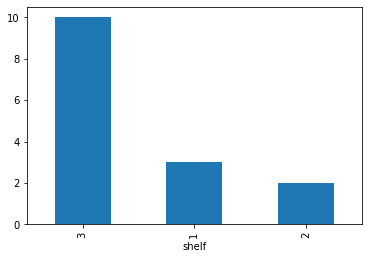

In [280]:
# shelf #3 has most of the healthy cerials
df[df["healthiness"] == "healthy"].groupby("shelf")\
    .size().sort_values(ascending=False).plot(kind="bar");

### **Question 11.** _(1 point)_
* Based on the analysis conducted, what can you conclude about the cereal data set?

In [285]:
df.describe()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.0,77.000000,77.000000
mean,103.996910,2.545455,1.012987,159.675325,2.151948,14.792208,7.025974,98.441558,28.246753,2.207792,1.0,0.821039,42.665705
std,13.851864,1.094790,1.006473,83.832295,2.383364,3.882612,4.349755,69.491857,22.342523,0.832524,0.0,0.232716,14.047289
min,50.000000,1.000000,0.000000,0.000000,0.000000,5.000000,0.000000,15.000000,0.000000,1.000000,1.0,0.250000,18.042851
25%,100.000000,2.000000,0.000000,130.000000,1.000000,12.000000,3.000000,45.000000,25.000000,1.000000,1.0,0.670000,33.174094
50%,106.666667,3.000000,1.000000,180.000000,2.000000,14.000000,7.000000,90.000000,25.000000,2.000000,1.0,0.750000,40.400208
75%,110.000000,3.000000,2.000000,210.000000,3.000000,17.000000,11.000000,120.000000,25.000000,3.000000,1.0,1.000000,50.828392
max,150.000000,6.000000,5.000000,320.000000,14.000000,23.000000,15.000000,330.000000,100.000000,3.000000,1.0,1.500000,93.704912


Overview:
- The data set is decent as is mostly have all the necessary data for analysis, except a few missing data points represented by a `-1`
- Unfortunately there is no type category and we have infer it from the name, which may be quite inaccurate.
- Finally the data set is fairly small, only 77 entries; however, despite a small size we seem to be able to identify a strong correlation between calories and rating.

In [292]:
df[df["healthiness"]=="healthy"]["healthiness"].describe()

count          15
unique          1
top       healthy
freq           15
Name: healthyness, dtype: object

Conclusions:
- The wast majority of cereals are unhealthy
- People looking for healthier options would likely find on the 3rd shelf
- People seem to give higher rating lower calories with lower calories count
- Looking at the destribution or ratings, we can conclude that either there is no correlation between high rading and "healthiness" or our definition of "healthiness" may not be the same as the one of the consumers